## Libraries and Packages

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import BatchNormalization
from sklearn import preprocessing
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras.applications import VGG16,VGG19,inception_v3
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from warnings import filterwarnings

import seaborn as sns
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
from pathlib import Path

import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix


### Importing Files

In [2]:
Train_Data_Path = Path("C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Training")
Test_Data_Path = Path("C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing")

In [3]:
Train_JPG_Path = list(Train_Data_Path.glob(r"*/*.jpg"))
Test_JPG_Path = list(Test_Data_Path.glob(r"*/*.jpg"))

In [4]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))

In [90]:
print("glioma: ", Train_JPG_Labels.count("glioma_tumor"))
print("meningioma: ", Train_JPG_Labels.count("meningioma_tumor"))
print("no: ", Train_JPG_Labels.count("no_tumor"))
print("pituitary: ", Train_JPG_Labels.count("pituitary_tumor"))

glioma:  826
meningioma:  822
no:  395
pituitary:  827


In [6]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [89]:
print("glioma: ", Test_JPG_Labels.count("glioma_tumor"))
print("meningioma: ", Test_JPG_Labels.count("meningioma_tumor"))
print("no: ", Test_JPG_Labels.count("no_tumor"))
print("pituitary: ", Test_JPG_Labels.count("pituitary_tumor"))

glioma:  100
meningioma:  115
no:  105
pituitary:  74


### Transformation to Series

In [8]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels,name="CATEGORY")
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="CATEGORY")

### Transformation to DataFrame

In [9]:
Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Series],axis=1)

### Shuffling Dataset

In [10]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

# Visualization

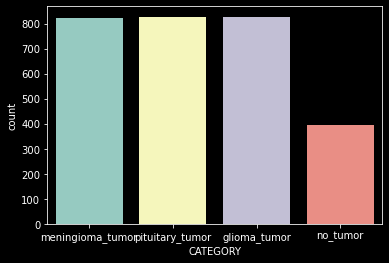

In [11]:
plt.style.use("dark_background")
sns.countplot(Main_Train_Data["CATEGORY"])
plt.show()

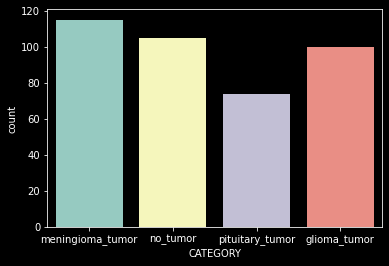

In [12]:
sns.countplot(Main_Test_Data["CATEGORY"])
plt.show()

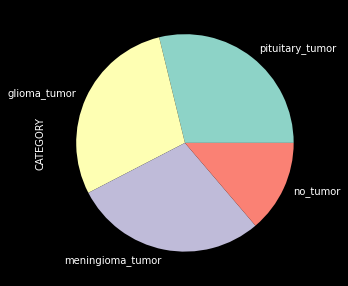

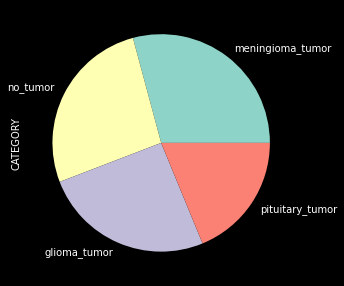

In [13]:
Main_Train_Data['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()
Main_Test_Data['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()

Text(0.5, 1.0, 'meningioma_tumor')

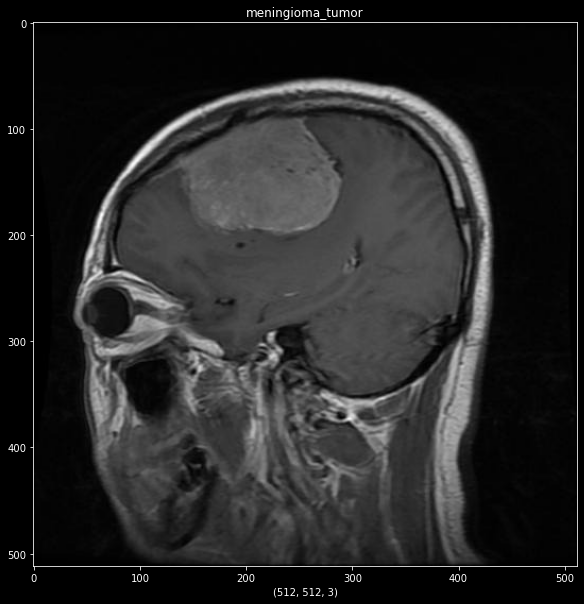

In [14]:
figure = plt.figure(figsize=(10,10))
x = plt.imread(Main_Train_Data["JPG"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][0])

Text(0.5, 1.0, 'glioma_tumor')

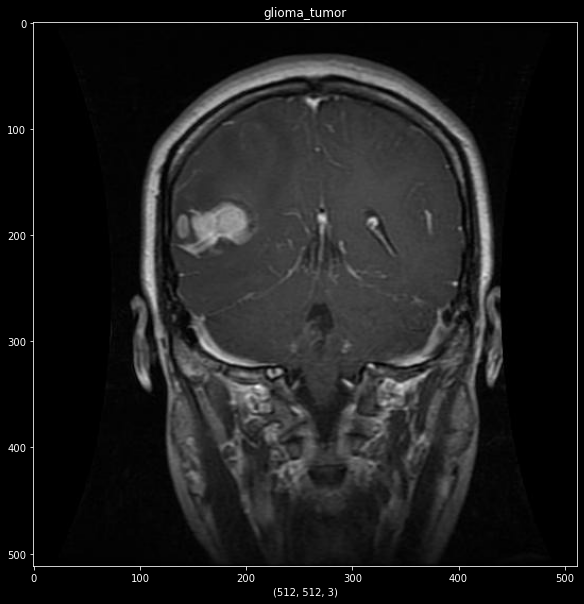

In [15]:
figure = plt.figure(figsize=(10,10))
x = plt.imread(Main_Train_Data["JPG"][1888])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Train_Data["CATEGORY"][1888])

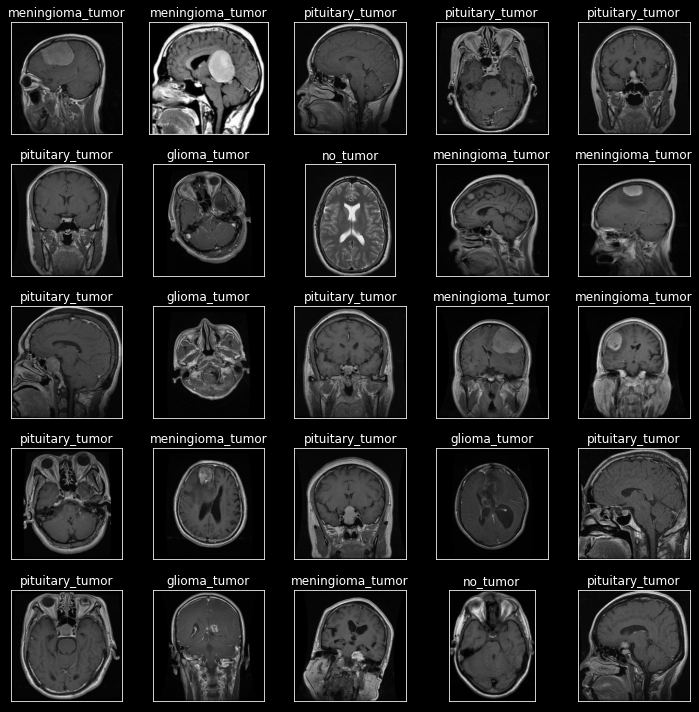

In [16]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["CATEGORY"][i])
plt.tight_layout()
plt.show()

## Data/Image Preprocessing

In [17]:
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.7,
                                    shear_range=0.7,
                                    rotation_range=50,
                                    horizontal_flip=True,
                                     brightness_range=[0.2,0.9],
                                     vertical_flip=True)

In [18]:
Test_Val_Generator = ImageDataGenerator(rescale=1./255,validation_split=0.5)

In [19]:
example_Image = Main_Train_Data["JPG"][30]
Load_Image = image.load_img(example_Image,target_size=(210,210))
Array_Image = image.img_to_array(Load_Image)
Array_Image = Array_Image.reshape((1,) + Array_Image.shape)

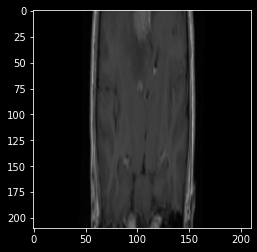

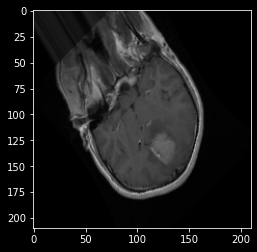

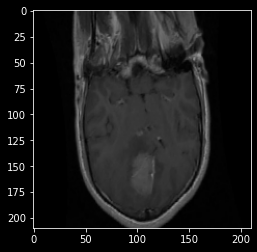

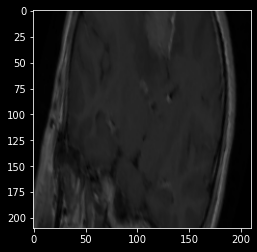

In [20]:
i = 0
for batch in Train_Generator.flow(Array_Image,batch_size=5):
    plt.figure(i)
    Image = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [21]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Main_Train_Data,
                                                   x_col="JPG",
                                                   y_col="CATEGORY",
                                                   color_mode="grayscale",
                                                   class_mode="categorical",
                                                   subset="training",
                                                   seed=42,
                                                   batch_size=16)

Found 2870 validated image filenames belonging to 4 classes.


In [22]:
Test_IMG_Set = Test_Val_Generator.flow_from_dataframe(dataframe=Main_Test_Data,
                                                   x_col="JPG",
                                                   y_col="CATEGORY",
                                                   color_mode="grayscale",
                                                   class_mode="categorical",
                                                   seed=42,
                                                   batch_size=16)

Found 394 validated image filenames belonging to 4 classes.


In [23]:
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 256, 256, 1)
LABEL SHAPE:  (16, 4)


In [24]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 256, 256, 1)
LABEL SHAPE:  (16, 4)


In [25]:
print("TRAIN: ")
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)
print("---"*20)
print("---"*20)
print("TEST: ")
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

TRAIN: 
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
[1, 1, 3, 3, 3]
(256, 256, 1)
------------------------------------------------------------
------------------------------------------------------------
TEST: 
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
[1, 2, 1, 3, 3]
(256, 256, 1)


### Call Back

In [26]:
Call_Back_Early = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                   patience=5,
                                                   mode="min")
Call_Back_Check = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                     save_best_only=True,
                                                    filepath="./my_model")

# For CNN with Conv 2d (Model 1)

In [27]:
Model_1 = Sequential()

#
Model_1.add(Conv2D(32,(3,3),activation="relu",
                 input_shape=(256,256,1)))
Model_1.add(MaxPooling2D((2,2)))
Model_1.add(Dropout(0.2))
#
Model_1.add(Conv2D(64,(3,3),activation="relu",
                 strides=(2,2)))
Model_1.add(MaxPooling2D((2,2)))
Model_1.add(Dropout(0.2))
#
Model_1.add(Conv2D(128,(3,3),activation="relu",
                 strides=(2,2)))
Model_1.add(MaxPooling2D((2,2)))
Model_1.add(Dropout(0.2))
#
Model_1.add(Conv2D(128,(3,3),activation="relu",
                 strides=(2,2)))
Model_1.add(MaxPooling2D((2,2)))
Model_1.add(Dropout(0.2))

#
Model_1.add(Flatten())
Model_1.add(Dropout(0.5))
Model_1.add(Dense(512,activation="relu"))
Model_1.add(Dense(4,activation="softmax"))
Model_1.summary()
number_of_layers = len(Model_1.layers)
print("Number of layers:", number_of_layers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 64)        0

In [28]:
Model_1.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
CNN_Model_1 = Model_1.fit(Train_IMG_Set,
                      validation_data=Test_IMG_Set,
                            callbacks=[Call_Back_Check,Call_Back_Early],
                      epochs=50)

Epoch 1/50
180/180 [==============================] - 55s 302ms/step - loss: 1.3560 - accuracy: 0.2836 - val_loss: 1.4347 - val_accuracy: 0.3503
Epoch 2/50
180/180 [==============================] - 52s 290ms/step - loss: 1.3283 - accuracy: 0.3474 - val_loss: 1.4443 - val_accuracy: 0.2919
Epoch 3/50
180/180 [==============================] - 55s 303ms/step - loss: 1.3039 - accuracy: 0.3697 - val_loss: 1.4289 - val_accuracy: 0.3046
Epoch 4/50
180/180 [==============================] - 56s 313ms/step - loss: 1.3007 - accuracy: 0.3728 - val_loss: 1.4934 - val_accuracy: 0.2208
Epoch 5/50
180/180 [==============================] - 57s 313ms/step - loss: 1.2883 - accuracy: 0.3749 - val_loss: 1.7111 - val_accuracy: 0.2157
Epoch 6/50
180/180 [==============================] - 57s 315ms/step - loss: 1.2757 - accuracy: 0.3927 - val_loss: 1.4999 - val_accuracy: 0.2690
Epoch 7/50
180/180 [==============================] - 57s 314ms/step - loss: 1.2781 - accuracy: 0.3913 - val_loss: 1.6363 - val_ac

In [29]:
Model_Results_1 = Model_1.evaluate(Test_IMG_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results_1[0])
print("ACCURACY:  " + "%.2f" % Model_Results_1[1])

LOSS:  1.9228
ACCURACY:  0.43


<AxesSubplot:>

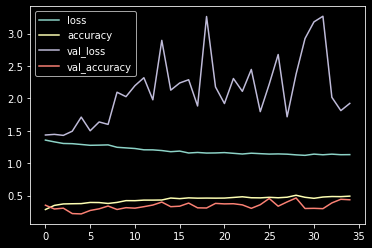

In [30]:
Dict_Summary_1 = pd.DataFrame(CNN_Model_1.history)
Dict_Summary_1.plot()

In [31]:
Prediction_1 = Model_1.predict(Test_IMG_Set)
Prediction_1 = Prediction_1.argmax(axis=-1)

# For R-CNN Model (Model 2)

In [32]:
Model_2 = Sequential()

Model_2.add(Conv2D(12,(3,3),activation="relu",
                 input_shape=(256,256,1)))
Model_2.add(BatchNormalization())
Model_2.add(MaxPooling2D((2,2)))

#
Model_2.add(Conv2D(24,(3,3),
                 activation="relu",padding="same"))
Model_2.add(Dropout(0.2))
Model_2.add(MaxPooling2D((2,2)))


#
Model_2.add(TimeDistributed(Flatten()))
Model_2.add(Bidirectional(LSTM(32,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))
Model_2.add(Bidirectional(GRU(32,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))

#
Model_2.add(Flatten())
Model_2.add(Dense(512,activation="relu"))
Model_2.add(Dropout(0.5))
Model_2.add(Dense(256,activation="relu"))
Model_2.add(Dropout(0.5))
Model_2.add(Dense(4,activation="softmax"))
Model_2.summary()
number_of_layers = len(Model_2.layers)
print("Number of layers:", number_of_layers)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 12)      120       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 12)     48        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 12)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 127, 127, 24)      2616      
                                                                 
 dropout_5 (Dropout)         (None, 127, 127, 24)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 24)      

In [33]:
Model_2.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
RCNN_Model_2 = Model_2.fit(Train_IMG_Set,
                      validation_data=Test_IMG_Set,
                            callbacks=[Call_Back_Check,Call_Back_Early],
                      epochs=50)

Epoch 1/50
180/180 [==============================] - 137s 724ms/step - loss: 1.4502 - accuracy: 0.3115 - val_loss: 1.6419 - val_accuracy: 0.2462
Epoch 2/50
180/180 [==============================] - 115s 641ms/step - loss: 1.3545 - accuracy: 0.3397 - val_loss: 1.5018 - val_accuracy: 0.2030
Epoch 3/50
180/180 [==============================] - 121s 673ms/step - loss: 1.3414 - accuracy: 0.3533 - val_loss: 1.4971 - val_accuracy: 0.2157
Epoch 4/50
180/180 [==============================] - 124s 692ms/step - loss: 1.3229 - accuracy: 0.3693 - val_loss: 1.5277 - val_accuracy: 0.2462
Epoch 5/50
180/180 [==============================] - 125s 692ms/step - loss: 1.3055 - accuracy: 0.3666 - val_loss: 1.7221 - val_accuracy: 0.2716
Epoch 6/50
180/180 [==============================] - 123s 682ms/step - loss: 1.3090 - accuracy: 0.3763 - val_loss: 1.3841 - val_accuracy: 0.3629
Epoch 7/50
180/180 [==============================] - 125s 693ms/step - loss: 1.2797 - accuracy: 0.3882 - val_loss: 2.6713 -

In [34]:
Model_Results_2 = Model_2.evaluate(Test_IMG_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results_2[0])
print("ACCURACY:  " + "%.2f" % Model_Results_2[1])

LOSS:  1.5842
ACCURACY:  0.37


<AxesSubplot:>

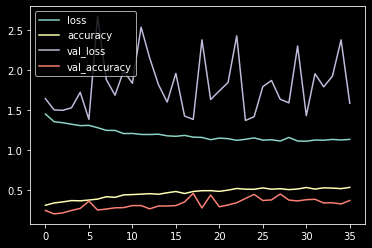

In [35]:
Dict_Summary_2 = pd.DataFrame(RCNN_Model_2.history)
Dict_Summary_2.plot()

In [36]:
Prediction_2 = Model_2.predict(Test_IMG_Set)
Prediction_2 = Prediction_2.argmax(axis=-1)

# 2nd Approach using CNN models

#### Again using CNN models with a different approach, the models have been trained and tested

In [37]:
import os
for dirname, _, filenames in os.walk('C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(1).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(10).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(100).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(11).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(12).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(13).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(14).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(15).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(16).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glioma_tumor\image(17).jpg
C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Testing\glio

### Importing Dataset

In [38]:
path = r"C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Training"

categories = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

### Data/Image Preprocessing

In [39]:
training_data = []
IMG_SIZE=150
def create_training_data():
    for category in categories :
        path_Data = os.path.join(path,category)
        class_num = categories.index(category)
        for img in os.listdir(path_Data):
            try:
                img_array = cv2.imread(os.path.join(path_Data,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [40]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2870, 150, 150)


(-0.5, 149.5, 149.5, -0.5)

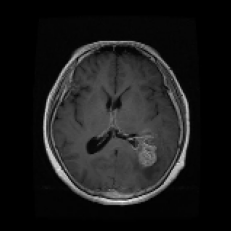

In [41]:
img_size = 150

img_array = cv2.imread('C:\Study\Sem - 4\Healthcare\Mini Project\Research\Dataset\Training\glioma_tumor\gg (10).jpg')
new_arr = cv2.resize(img_array,(img_size,img_size))
plt.imshow(new_arr,cmap='gray')
plt.axis("off")

In [42]:
y = to_categorical(y, num_classes = 4)

## Splitting Data

In [43]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [44]:
print("X train shape",X_train.shape)
print("X test shape",X_test.shape)
print("Y train shape",Y_train.shape)
print("Y test shape",Y_test.shape)

X train shape (2009, 150, 150, 1)
X test shape (861, 150, 150, 1)
Y train shape (2009, 4)
Y test shape (861, 4)


In [45]:
datagen=ImageDataGenerator(
    featurewise_center =False,
    samplewise_center = False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True,
    vertical_flip=False)

# For CNN with Conv 2d (Model 3)

In [48]:
Model_3=Sequential()
Model_3.add(Conv2D(filters=64,kernel_size = (5,5), padding='Same',activation ='relu' ,input_shape=(150,150,1)))
Model_3.add(MaxPool2D(pool_size=(2,2)))
Model_3.add(Dropout(0.25))

Model_3.add(Conv2D(filters=128,kernel_size = (3,3), padding='Same', activation='relu'))
Model_3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
Model_3.add(Dropout(0.25))

Model_3.add(Conv2D(filters=256,kernel_size = (2,2), padding='Same', activation='relu'))
Model_3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Model_3.add(Dropout(0.3))

Model_3.add(Flatten())
Model_3.add(Dense(1024,activation='relu'))
Model_3.add(Dropout(0.5))
Model_3.add(Dense(4, activation="softmax"))
opti = Adam(lr=0.001, beta_1=0.9,beta_2=0.999)
Model_3.compile(optimizer=opti,loss ='categorical_crossentropy',metrics=['accuracy'])
epochs = 20
batch_size=40
Model_3.summary()
number_of_layers = len(Model_3.layers)
print("Number of layers:", number_of_layers)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 64)      1664      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 128)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 37, 37, 128)      

In [49]:
datagen.fit(X_train)

CNN_Model_3 = Model_3.fit(datagen.flow(X_train,Y_train,batch_size = 40), epochs = 50 ,
                          validation_data=(X_test,Y_test),
                    verbose=1, callbacks=[Call_Back_Early, Call_Back_Check])

Epoch 1/50
51/51 [==============================] - 103s 2s/step - loss: 1.4719 - accuracy: 0.4495 - val_loss: 1.1022 - val_accuracy: 0.5517
Epoch 2/50
51/51 [==============================] - 97s 2s/step - loss: 0.9442 - accuracy: 0.5968 - val_loss: 0.8023 - val_accuracy: 0.6446
Epoch 3/50
51/51 [==============================] - 99s 2s/step - loss: 0.7778 - accuracy: 0.6670 - val_loss: 0.6765 - val_accuracy: 0.7038
Epoch 4/50
51/51 [==============================] - 101s 2s/step - loss: 0.6857 - accuracy: 0.7103 - val_loss: 0.7786 - val_accuracy: 0.7050
Epoch 5/50
51/51 [==============================] - 95s 2s/step - loss: 0.5907 - accuracy: 0.7611 - val_loss: 0.6393 - val_accuracy: 0.7073
Epoch 6/50
51/51 [==============================] - 89s 2s/step - loss: 0.5252 - accuracy: 0.7899 - val_loss: 0.5252 - val_accuracy: 0.7735
Epoch 7/50
51/51 [==============================] - 90s 2s/step - loss: 0.4305 - accuracy: 0.8228 - val_loss: 0.4997 - val_accuracy: 0.7758
Epoch 8/50
51/51 [

In [50]:
Model_Results_3 = Model_3.evaluate(X_test,Y_test,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results_3[0])
print("ACCURACY:  " + "%.2f" % Model_Results_3[1])

LOSS:  0.3868
ACCURACY:  0.89


<AxesSubplot:>

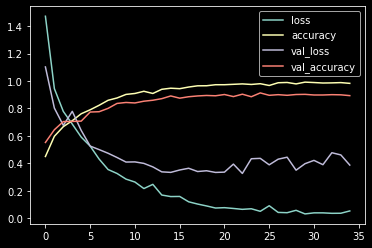

In [51]:
Dict_Summary_3 = pd.DataFrame(CNN_Model_3.history)
Dict_Summary_3.plot()

In [52]:
Prediction_3 = Model_3.predict(X_test)
Prediction_3 = Prediction_3.argmax(axis=-1)

# For CNN Model 3 (Model 4)

In [53]:
Model_4 = Sequential()
Model_4.add(Conv2D(filters=64,kernel_size = (5,5), padding='Same',activation ='relu' ,input_shape=(150,150,1)))
Model_4.add(MaxPool2D(pool_size=(2,2)))
Model_4.add(Dropout(0.25))

Model_4.add(Conv2D(filters=128,kernel_size = (3,3), padding='Same', activation='relu'))
Model_4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
Model_4.add(Dropout(0.25))

Model_4.add(Conv2D(filters=128,kernel_size = (3,3), padding='Same', activation='relu'))
Model_4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
Model_4.add(Dropout(0.3))


Model_4.add(Conv2D(filters=256,kernel_size = (2,2), padding='Same', activation='relu'))
Model_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Model_4.add(Dropout(0.3))



Model_4.add(Flatten())
Model_4.add(Dense(1024,activation='relu'))
Model_4.add(Dropout(0.5))
Model_4.add(Dense(4, activation="softmax"))
opti = Adam(lr=0.001, beta_1=0.9,beta_2=0.999)
Model_4.compile(optimizer=opti,loss ='categorical_crossentropy',metrics=['accuracy'])
epochs = 50
batch_size=40
Model_4.summary()
number_of_layers = len(Model_4.layers)
print("Number of layers:", number_of_layers)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 64)      1664      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 128)      0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 37, 37, 128)      

In [54]:
datagen.fit(X_train)
CNN_Model_4 = Model_4.fit(datagen.flow(X_train,Y_train,batch_size = 40), epochs = 50 ,
                          validation_data=(X_test,Y_test),
                    verbose=1, callbacks=[Call_Back_Early, Call_Back_Check])

Epoch 1/50
51/51 [==============================] - 70s 1s/step - loss: 1.2205 - accuracy: 0.4500 - val_loss: 1.1559 - val_accuracy: 0.4913
Epoch 2/50
51/51 [==============================] - 70s 1s/step - loss: 0.9586 - accuracy: 0.6023 - val_loss: 1.1166 - val_accuracy: 0.5064
Epoch 3/50
51/51 [==============================] - 69s 1s/step - loss: 0.8192 - accuracy: 0.6446 - val_loss: 0.7913 - val_accuracy: 0.6492
Epoch 4/50
51/51 [==============================] - 69s 1s/step - loss: 0.7330 - accuracy: 0.6784 - val_loss: 0.8196 - val_accuracy: 0.6167
Epoch 5/50
51/51 [==============================] - 70s 1s/step - loss: 0.6522 - accuracy: 0.7237 - val_loss: 0.6358 - val_accuracy: 0.7619
Epoch 6/50
51/51 [==============================] - 69s 1s/step - loss: 0.5854 - accuracy: 0.7601 - val_loss: 0.5969 - val_accuracy: 0.7096
Epoch 7/50
51/51 [==============================] - 69s 1s/step - loss: 0.5223 - accuracy: 0.7899 - val_loss: 0.6774 - val_accuracy: 0.6609
Epoch 8/50
51/51 [==

In [55]:
Model_Results_4 = Model_4.evaluate(X_test,Y_test,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results_4[0])
print("ACCURACY:  " + "%.2f" % Model_Results_4[1])

LOSS:  0.3658
ACCURACY:  0.91


<AxesSubplot:>

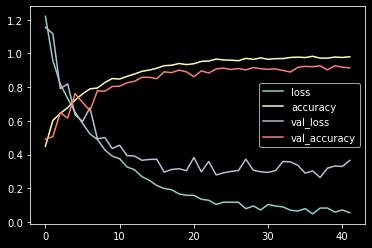

In [56]:
Dict_Summary_4 = pd.DataFrame(CNN_Model_4.history)
Dict_Summary_4.plot()

In [57]:
Prediction_4 = Model_4.predict(X_test)
Prediction_4 = Prediction_4.argmax(axis=-1)

## Comparison

In [59]:
import matplotlib.pyplot as plt

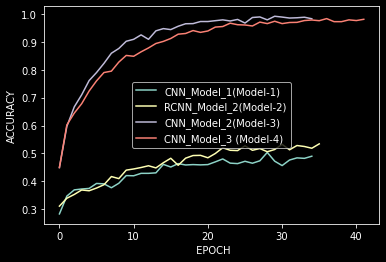

In [88]:
# pl the lines
plt.plot(CNN_Model_1.history["accuracy"])
plt.plot(RCNN_Model_2.history["accuracy"])
plt.plot(CNN_Model_3.history["accuracy"])
plt.plot(CNN_Model_4.history["accuracy"])
plt.ylabel("ACCURACY")
plt.xlabel(" EPOCH")
# add a lege
plt.legend(['CNN_Model_1(Model-1)','RCNN_Model_2(Model-2)','CNN_Model_2(Model-3)','CNN_Model_3 (Model-4)'])

# display the plot
plt.show()

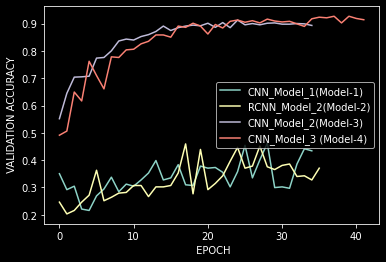

In [87]:
# pl the lines
plt.plot(CNN_Model_1.history["val_accuracy"])
plt.plot(RCNN_Model_2.history["val_accuracy"])
plt.plot(CNN_Model_3.history["val_accuracy"])
plt.plot(CNN_Model_4.history["val_accuracy"])
plt.ylabel(" VALIDATION ACCURACY")
plt.xlabel(" EPOCH")
# add a lege
plt.legend(['CNN_Model_1(Model-1)','RCNN_Model_2(Model-2)','CNN_Model_2(Model-3)','CNN_Model_3 (Model-4)'])

# display the plot
plt.show()